In [14]:
# =============================
# 📦 Standard Libraries
# =============================
import re

# =============================
# 🧪 Data Science & ML Libraries
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)

# =============================
# 🧠 NLP Libraries
# =============================
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# =============================
# 🤗 Transformers (RoBERTa)
# =============================
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# =============================
# 🔄 Progress Bars
# =============================
from tqdm.notebook import tqdm

# =============================
# ⬇️ One-time NLTK Downloads
# =============================
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/arghadeep/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/arghadeep/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/arghadeep/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/arghadeep/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/arghadeep/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv('train.csv')
# df = df.sample(1000)
df.columns = ['Id', 'text', 'selected_text', 'sentiment']
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)            # remove URLs
    text = re.sub(r"<.*?>", "", text)              # remove HTML
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)     # remove punctuation (keep emojis)
    text = text.strip().lower()
    return text

df['clean_text'] = df['text'].apply(clean_text)


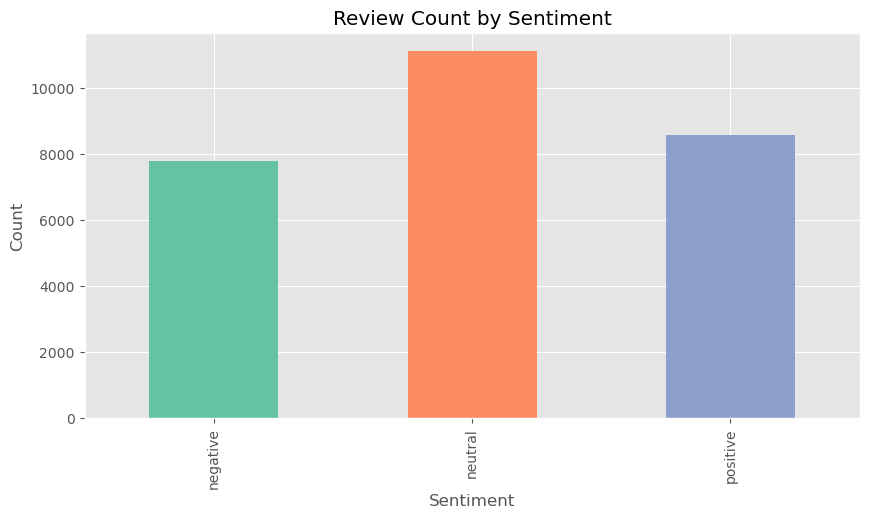

In [4]:
review_score_counts = df['sentiment'].value_counts().sort_index()
colors = sns.color_palette('Set2', n_colors=len(review_score_counts))

ax = review_score_counts.plot(kind='bar', title='Review Count by Sentiment', figsize=(10, 5), color=colors)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()


In [5]:
sia = SentimentIntensityAnalyzer()

vader_results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    vader_result = sia.polarity_scores(row['clean_text'])
    vader_results[row['Id']] = {f'vader_{k}': v for k, v in vader_result.items()}

vader_df = pd.DataFrame(vader_results).T.reset_index().rename(columns={'index': 'Id'})
df = df.merge(vader_df, how='left')


  0%|          | 0/27480 [00:00<?, ?it/s]

In [6]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def polarity_scores_roberta_batch(contents):
    encoded = tokenizer(contents, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        output = model(**encoded)
        probs = softmax(output.logits.numpy(), axis=1)
        return [
            {'roberta_neg': float(p[0]), 'roberta_neu': float(p[1]), 'roberta_pos': float(p[2])}
            for p in probs
        ]

# Apply in batches
roberta_results = []
batch_size = 64
for i in tqdm(range(0, len(df), batch_size)):
    batch_text = df['clean_text'].iloc[i:i+batch_size].tolist()
    batch_scores = polarity_scores_roberta_batch(batch_text)
    roberta_results.extend(batch_scores)

roberta_df = pd.DataFrame(roberta_results)
df = pd.concat([df.reset_index(drop=True), roberta_df], axis=1)


  0%|          | 0/430 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


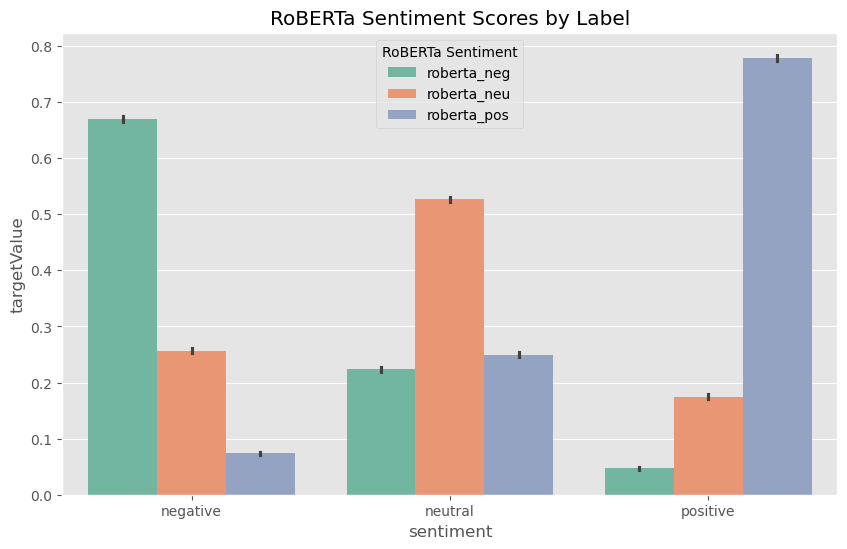

In [7]:
# Combine melted RoBERTa
melted = df.melt(id_vars='sentiment', 
                 value_vars=['roberta_neg', 'roberta_neu', 'roberta_pos'], 
                 var_name='Sentiment', 
                 value_name='targetValue')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=melted, x='sentiment', y='targetValue', hue='Sentiment', order=['negative','neutral','positive'], palette='Set2')
ax.set_title('RoBERTa Sentiment Scores by Label')
plt.legend(title='RoBERTa Sentiment')
plt.show()


In [8]:
# RoBERTa: Negative labeled but high positive
print("RoBERTa: Negative → High Positive")
print(df[df['sentiment']=='negative'].sort_values('roberta_pos', ascending=False).iloc[0][['text','roberta_pos']])

# VADER: Negative labeled but high positive
print("VADER: Negative → High Positive")
print(df[df['sentiment']=='negative'].sort_values('vader_pos', ascending=False).iloc[0][['text','vader_pos']])

# RoBERTa: Positive labeled but high negative
print("RoBERTa: Positive → High Negative")
print(df[df['sentiment']=='positive'].sort_values('roberta_neg', ascending=False).iloc[0][['text','roberta_neg']])

# VADER: Positive labeled but high negative
print("VADER: Positive → High Negative")
print(df[df['sentiment']=='positive'].sort_values('vader_neg', ascending=False).iloc[0][['text','vader_neg']])


RoBERTa: Negative → High Positive
text            have an amazing time with your mommas tomorro...
roberta_pos                                             0.992341
Name: 15215, dtype: object
VADER: Negative → High Positive
text          Awww, *hugs* I wish I could help.
vader_pos                                 0.811
Name: 17483, dtype: object
RoBERTa: Positive → High Negative
text           i ditched school ( i hate it ) and im taking a...
roberta_neg                                             0.980429
Name: 11891, dtype: object
VADER: Positive → High Negative
text          No worries
vader_neg            1.0
Name: 5807, dtype: object


In [9]:
def classify_roberta(row):
    scores = [row['roberta_pos'], row['roberta_neu'], row['roberta_neg']]
    labels = ['positive', 'neutral', 'negative']
    return labels[np.argmax(scores)]

def classify_vader(row):
    scores = [row['vader_pos'], row['vader_neu'], row['vader_neg']]
    labels = ['positive', 'neutral', 'negative']
    return labels[np.argmax(scores)]

df['roberta_pred'] = df.apply(classify_roberta, axis=1)
df['vader_pred'] = df.apply(classify_vader, axis=1)


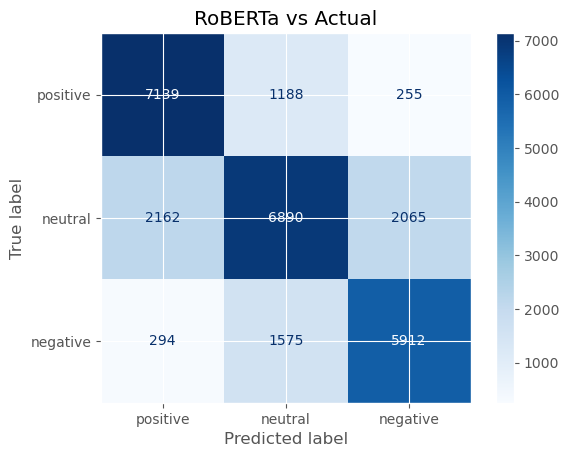

              precision    recall  f1-score   support

    negative       0.72      0.76      0.74      7781
     neutral       0.71      0.62      0.66     11117
    positive       0.74      0.83      0.79      8582

    accuracy                           0.73     27480
   macro avg       0.73      0.74      0.73     27480
weighted avg       0.72      0.73      0.72     27480



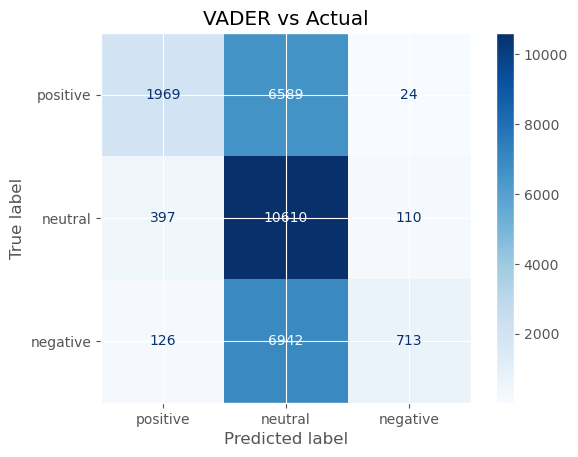

              precision    recall  f1-score   support

    negative       0.84      0.09      0.17      7781
     neutral       0.44      0.95      0.60     11117
    positive       0.79      0.23      0.36      8582

    accuracy                           0.48     27480
   macro avg       0.69      0.43      0.37     27480
weighted avg       0.66      0.48      0.40     27480



In [10]:
def display_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'neutral', 'negative'])
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()
    print(classification_report(y_true, y_pred))

display_confusion(df['sentiment'], df['roberta_pred'], "RoBERTa vs Actual")
display_confusion(df['sentiment'], df['vader_pred'], "VADER vs Actual")


In [11]:
df['text_len'] = df['clean_text'].apply(len)
df['num_words'] = df['clean_text'].apply(lambda x: len(x.split()))
df['has_exclam'] = df['text'].apply(lambda x: int('!' in x))
df['has_question'] = df['text'].apply(lambda x: int('?' in x))

In [12]:
features = [
    'vader_compound',
    'roberta_pos', 'roberta_neu', 'roberta_neg',
    'text_len', 'num_words', 'has_exclam', 'has_question'
]
X = df[features]
y = df['sentiment']

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)



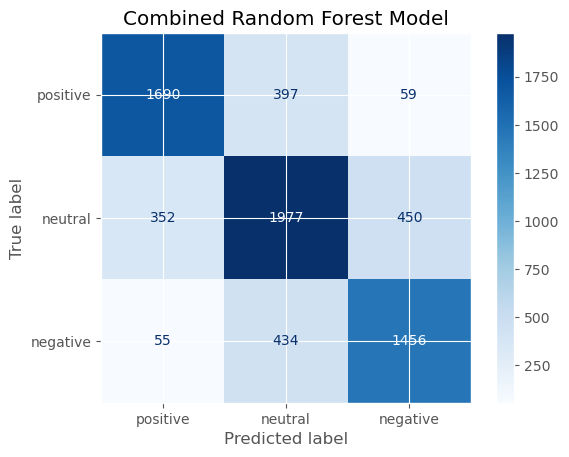

              precision    recall  f1-score   support

    negative       0.74      0.75      0.74      1945
     neutral       0.70      0.71      0.71      2779
    positive       0.81      0.79      0.80      2146

    accuracy                           0.75      6870
   macro avg       0.75      0.75      0.75      6870
weighted avg       0.75      0.75      0.75      6870



In [16]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

display_confusion(y_test, y_pred, "Combined Random Forest Model")


In [31]:
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))

Macro F1 Score: 0.749692514992586


In [32]:
import joblib
from pathlib import Path

# Create a directory to store models
Path("models").mkdir(exist_ok=True)

# 1. Save StandardScaler
joblib.dump(scaler, "models/scaler.pkl")

# 2. Save Random Forest model
joblib.dump(clf, "models/sentiment_model.pkl")

# 3. Save RoBERTa model and tokenizer (huggingface format)
model.save_pretrained("models/roberta_model")
tokenizer.save_pretrained("models/roberta_model")

print("✅ All models saved in 'saved_models/' directory")


✅ All models saved in 'saved_models/' directory
